# DECODE - General Introduction
If you plan to install and use DECODE locally we recommend going through this notebook to get familiar with the framework.

We make highly use of the CUDA accelerated library PyTorch which is used internally almost everywhere.

In [1]:
import decode
import decode.utils  # interfaces to outside world which are not loaded by default
import torch

print(f"DECODE version: {decode.utils.bookkeeping.decode_state()}")

DECODE version: vINVALID-recent-0.10.0


In [2]:
help(decode.EmitterSet)

Help on class EmitterSet in module decode.generic.emitter:

class EmitterSet(builtins.object)
 |  EmitterSet(xyz: torch.Tensor, phot: torch.Tensor, frame_ix: torch.LongTensor, id: torch.LongTensor = None, prob: torch.Tensor = None, bg: torch.Tensor = None, xyz_cr: torch.Tensor = None, phot_cr: torch.Tensor = None, bg_cr: torch.Tensor = None, xyz_sig: torch.Tensor = None, phot_sig: torch.Tensor = None, bg_sig: torch.Tensor = None, sanity_check: bool = True, xy_unit: str = None, px_size: Union[tuple, torch.Tensor] = None)
 |  
 |  Class, storing a set of emitters and its attributes. Probably the most commonly used class of this framework.
 |  
 |  Attributes:
 |          xyz: Coordinates of size N x [2,3].
 |          phot: Photon count of size N
 |          frame_ix: size N. Index on which the emitter appears.
 |          id: size N. Identity the emitter.
 |          prob: size N. Probability estimate of the emitter.
 |          bg: size N. Background estimate of emitter.
 |          xy

## EmitterSet

At the core of DECODE is the EmitterSet. It has a lot of important functionalities which one should know about. In an interactive Python session (such as this notebook or in the console) you can get more information of all implementations by `help([...])`, e.g.
> `help(decode.EmitterSet)`


In [3]:
# construct an EmitterSet
em = decode.EmitterSet(
    xyz=torch.tensor([[15., 15., 0.], [30., 10., 500.]]),
    phot=torch.tensor([1000, 500.]),
    frame_ix=torch.tensor([0, 100]),
    xy_unit='px', # z is always in nm
    px_size=(100., 100.))  # not strictly needed but recommended in order to access xyz in both 

print(em)  # get some info on the set of emitters

EmitterSet
::num emitters: 2
::xy unit: px
::px size: tensor([100., 100.])
::frame range: 0 - 100
::spanned volume: [15. 10.  0.] - [ 30.  15. 500.]


The coordinates can (and should) explicitly accessed with a unit as em.xyz_px or em.xyz_nm

In [4]:
em.xyz_nm

tensor([[1500., 1500.,    0.],
        [3000., 1000.,  500.]])

In [5]:
# you can also set coordinates in a new unit which will lead to automatic conversion
em.xyz_nm = torch.rand(2, 3)

print(em)  # you see now that the internal storage has changed from px units to nm

EmitterSet
::num emitters: 2
::xy unit: nm
::px size: tensor([100., 100.])
::frame range: 0 - 100
::spanned volume: [0.45017833 0.38343418 0.12582058] - [0.54885817 0.9230971  0.28832537]


### Save and Load Emitters
There a different options to save EmitterSets.

We support:
- HDF5 files: Well suited for large file, supported by many frameworks
- PT files: Pytorch native saving. Useful for debugging or fast i/o. Not for longterm storage.
- CSV files: Human readable and compatible with most other frameworks Compatible with most other frameworks, however highly discouraged if frequently used.

All of these formats are derived automatically by the file extension, i.e.

In [6]:
em.save('emitter.h5')  # or '.csv' or '.pt'

In [7]:
# load EmitterSet from file
em_clone = decode.EmitterSet.load('emitter.h5')

In [8]:
# to retrieve all information that is stored in the file, you can call the loaders explicitley
em_data, em_meta, decode_meta = decode.utils.emitter_io.load_h5('emitter.h5')  # load_h5 / load_torch / load_csv
em_reload = decode.EmitterSet(**em_data, **em_meta)

print(f"Decode meta information at the time of saving: {decode_meta}")

Decode meta information at the time of saving: {'version': 'vINVALID-recent-0.10.0'}


It is possible to load  csv files that deviate in their CSV header and columns. You
need to specify a mapping with keys at least: `x, y, z, phot,
frame_ix`
>We provide some 'batteries included' mappings, e.g. for the superres fight club challenge format.

In [ ]:
# this is the challenge mapping
decode.utils.emitter_io.challenge_mapping

In [ ]:
# uncomment the following lines and update the path if you have the challenge activations at hand

# em_challenge = decode.utils.emitter_io.load_csv('path_to_challenge_activations.csv',
#                                                 mapping=decode.utils.emitter_io.challenge_mapping,
#                                                 skiprows=0, line_em_meta=None, line_decode_meta=None)

### Operators and Helpers on EmitterSets
We implemented a couple of helpers for convenience

In [9]:
# we support boolean indexing of emitters
subset = em[[True, False]]

# e.g. get emitter on specific frame
em_sub = em[em.frame_ix == 0]

# e.g. emitters with certain photon count
em_bright = em[em.phot > 600.]

In [10]:
# check equality of two sets of emitters 
# warning: requires exact equality, i.e. even the order of localisations must be the same
em == em_clone

True

In [11]:
# iterate over emitters in set
[print(e) for e in em]

EmitterSet
::num emitters: 1
::xy unit: nm
::px size: tensor([100., 100.])
::frame range: 0 - 0
::spanned volume: [0.54885817 0.38343418 0.28832537] - [0.54885817 0.38343418 0.28832537]
EmitterSet
::num emitters: 1
::xy unit: nm
::px size: tensor([100., 100.])
::frame range: 100 - 100
::spanned volume: [0.45017833 0.9230971  0.12582058] - [0.45017833 0.9230971  0.12582058]


[None, None]

In [ ]:
# split emitterset in frames, indices are inclusive, ix_low=0, ix_up=2 will output a list of length 3
em_split = em.split_in_frames(ix_low=0, ix_up=10)  # outputs lists of EmitterSets per frame

In [ ]:
# split emitterset in 3 eqaul chunks
em = decode.RandomEmitterSet(8)
em_split = em.chunks(3)

print(f"{len(em_split)} splits of respective lengths {[len(e) for e in em_split]}.")

In [ ]:
# concatenate multiple emittersets together
em_cat = decode.EmitterSet.cat(em_split)

### Sampling Emitters
We provide some conveniences to sample or construct emitters

In [ ]:
em_random = decode.RandomEmitterSet(200)  # outputs 200 random emitters, see help(decode.RandomEmitterSet) for more information
print(em_random)

### Plotting Emitters in 2D and 3D

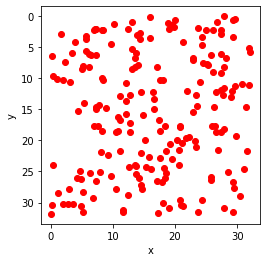

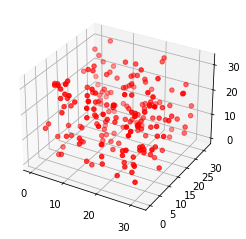

In [12]:
import matplotlib.pyplot as plt

em_fuzzy = decode.RandomEmitterSet(200)

decode.plot.PlotCoordinates(em_fuzzy.xyz_px).plot()
plt.show()

decode.plot.PlotCoordinates3D(em_fuzzy.xyz_px).plot()
plt.show()